## Perbandingan Classifikasi Menggunakan SVM dan Naive Bayes

In [55]:
import pandas as pd
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from joblib import dump, load

# Data Preparation

In [8]:
# Load dataset
data_play_store = pd.read_csv('Dataset\data_google_play.csv')
data_app_store = pd.read_csv('Dataset\data_app_store.csv')

In [9]:
data_play_store.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,6517985a-303c-452a-a28b-547e7e7b25f5,Eddy Supriyanto,https://play-lh.googleusercontent.com/a/ACg8oc...,good aplikasinya membantu sekali untuk transpe...,5,0,2.55.0,2024-05-05 21:07:05,"Makasih buat review nya, kalo ada keluhan hubu...",2024-05-05 21:08:20,2.55.0
1,6ca58bdc-e90f-4b87-964c-fa63283a92ff,Mainda Suaemu,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat membantu,5,3,2.55.0,2024-05-03 17:55:35,"Makasih buat review nya, kalo ada keluhan hubu...",2024-05-03 17:56:23,2.55.0
2,532c6a46-3cb1-4998-b6f2-66ae19e34a63,Rizki Febrian,https://play-lh.googleusercontent.com/a-/ALV-U...,saldo saya hilang 575.000 sampe sekarang gaada...,1,5,NaN,2024-05-02 17:46:19,"Hi Kak Rizku, Kami infoin DANA tdk pernah meng...",2024-05-02 18:47:51,NaN
3,64900f3f-5148-496a-bc21-d5fba9dbd8fe,Atalla Nanda,https://play-lh.googleusercontent.com/a-/ALV-U...,Terakhir kalinya ini saya pakai aplikasi payah...,1,2,2.55.0,2024-05-02 02:37:45,"Hi Kak Atalla, maaf atas kendala yg dialami. K...",2024-05-03 07:59:09,2.55.0
4,41a0c5dc-3d41-4357-9daa-c81e01765d27,Arfan Kurniawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Bagus,5,1,2.55.0,2024-05-01 22:07:10,"Makasih buat review nya, jangan lupa ajak teme...",2024-05-01 22:08:23,2.55.0


In [11]:
# memilih kolom yang akan digunakan
data_play_store = data_play_store[['at','userName', 'content','score']]

In [12]:
data_play_store.head()

,at,userName,content,score
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5
1,2024-05-03 17:55:35,Mainda Suaemu,Sangat membantu,5
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang 575.000 sampe sekarang gaada...,1
3,2024-05-02 02:37:45,Atalla Nanda,Terakhir kalinya ini saya pakai aplikasi payah...,1
4,2024-05-01 22:07:10,Arfan Kurniawan,Bagus,5


In [10]:
data_app_store.head()

,date,review,rating,isEdited,title,userName,developerResponse
0,2019-08-31 10:35:48,Sangat membantu cukup praktis dan banyak promo,5,False,upik,Upik.R,NaN
1,2020-12-20 01:49:48,Semua proses transaksi sangat smooth. \nUtk pe...,5,False,Praktis dan Aman,Moonshine and Coke,"{'id': 20182473, 'body': 'Terima kasih sudah m..."
2,2019-10-06 06:06:16,Kenapa saya kasih bintang 1? Ya mngkin ada kes...,1,False,Kecewa dengan pelayanan dana,kaka0996,NaN
3,2021-03-07 22:34:10,Dih najis kalau mau membayar kasih notif apa k...,1,False,Gblk,joeeeee harris,NaN
4,2019-10-08 15:57:08,"sudah 2hr TOPUP dana blm masuk saldo, makin ke...",5,False,TOPUP SALDO DANA MAKIN GAK JELAS,synori,NaN


In [13]:
# memilih kolom yang akan digunakan
data_app_store = data_app_store[['date','userName', 'review','rating']]

In [14]:
data_app_store.head()

,date,userName,review,rating
0,2019-08-31 10:35:48,Upik.R,Sangat membantu cukup praktis dan banyak promo,5
1,2020-12-20 01:49:48,Moonshine and Coke,Semua proses transaksi sangat smooth. \nUtk pe...,5
2,2019-10-06 06:06:16,kaka0996,Kenapa saya kasih bintang 1? Ya mngkin ada kes...,1
3,2021-03-07 22:34:10,joeeeee harris,Dih najis kalau mau membayar kasih notif apa k...,1
4,2019-10-08 15:57:08,synori,"sudah 2hr TOPUP dana blm masuk saldo, makin ke...",5


In [15]:
# mengganti nama kolom agar sama
data_play_store.columns = ['date', 'username', 'review', 'rating']
data_app_store.columns = ['date', 'username', 'review', 'rating']

In [16]:
# menggabungkan data
data = pd.concat([data_play_store, data_app_store])

In [17]:
data.head()

,date,username,review,rating
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5
1,2024-05-03 17:55:35,Mainda Suaemu,Sangat membantu,5
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang 575.000 sampe sekarang gaada...,1
3,2024-05-02 02:37:45,Atalla Nanda,Terakhir kalinya ini saya pakai aplikasi payah...,1
4,2024-05-01 22:07:10,Arfan Kurniawan,Bagus,5


In [18]:
# jumlah data
data.shape

(1597, 4)

In [19]:
# simpan data ke csv
data.to_csv('Dataset\data_review_dana.csv', index=False)

# Data Preprocessing

In [20]:
# Load data
data = pd.read_csv('Dataset\data_review_dana.csv')

In [21]:
data.head()

,date,username,review,rating
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5
1,2024-05-03 17:55:35,Mainda Suaemu,Sangat membantu,5
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang 575.000 sampe sekarang gaada...,1
3,2024-05-02 02:37:45,Atalla Nanda,Terakhir kalinya ini saya pakai aplikasi payah...,1
4,2024-05-01 22:07:10,Arfan Kurniawan,Bagus,5


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1597 non-null   object
 1   username  1597 non-null   object
 2   review    1597 non-null   object
 3   rating    1597 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 50.0+ KB


In [26]:
# mengubah date menjadi datetime
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1597 non-null   datetime64[ns]
 1   username  1597 non-null   object        
 2   review    1597 non-null   object        
 3   rating    1597 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 50.0+ KB


In [28]:
data.head()

,date,username,review,rating
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5
1,2024-05-03 17:55:35,Mainda Suaemu,Sangat membantu,5
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang 575.000 sampe sekarang gaada...,1
3,2024-05-02 02:37:45,Atalla Nanda,Terakhir kalinya ini saya pakai aplikasi payah...,1
4,2024-05-01 22:07:10,Arfan Kurniawan,Bagus,5


<Axes: xlabel='year'>

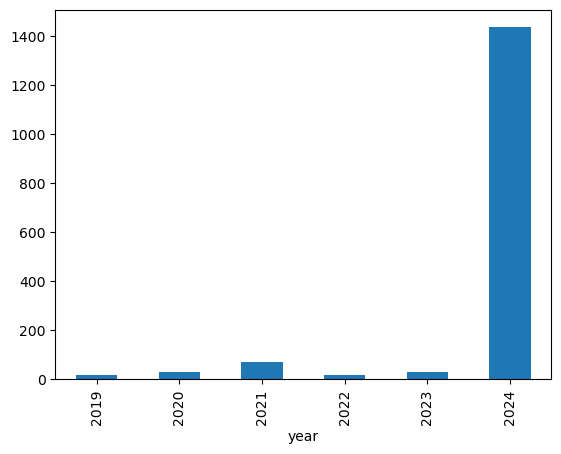

In [29]:
# visualisasi data berdasarkan tahun
data['year'] = data['date'].dt.year
data['year'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='rating'>

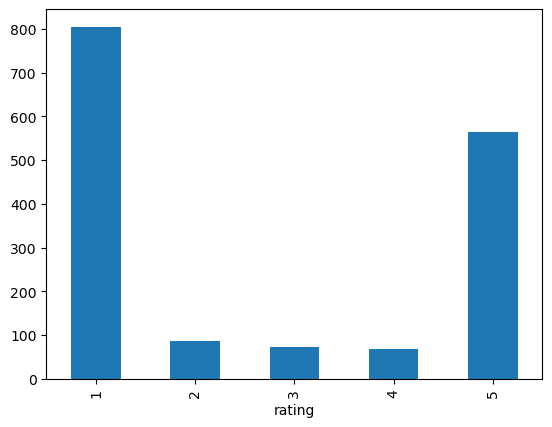

In [30]:
# visualisasi data berdasarkan rating
data['rating'].value_counts().sort_index().plot(kind='bar')

In [33]:
data['sentiment'] = np.where(data['rating'] > 3, 'positive', 'negative')

In [34]:
data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,Sangat membantu,5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang 575.000 sampe sekarang gaada...,1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,Terakhir kalinya ini saya pakai aplikasi payah...,1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,Bagus,5,2024,positive


<Axes: xlabel='sentiment'>

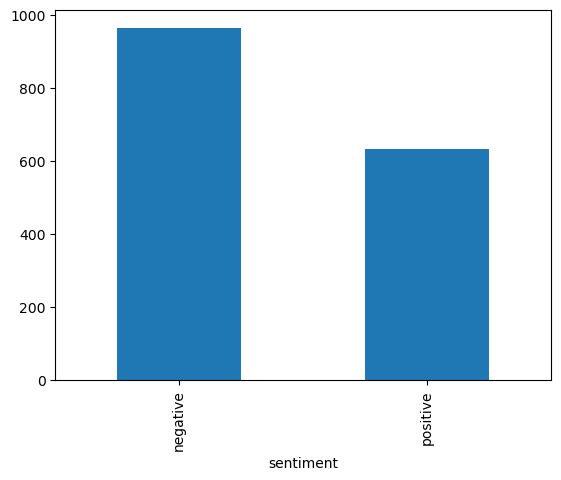

In [35]:
data['sentiment'].value_counts().plot(kind='bar')

## Data Cleaning

In [41]:
data.duplicated().sum()

0

In [42]:
data.isnull().sum()

date         0
username     0
review       0
rating       0
year         0
sentiment    0
dtype: int64

## Case Folding

In [43]:
data['review'] = data['review'].str.lower()

In [44]:
data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,sangat membantu,5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang 575.000 sampe sekarang gaada...,1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,terakhir kalinya ini saya pakai aplikasi payah...,1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,bagus,5,2024,positive


In [45]:
# hapus karakter selain huruf seperti angka dan simbol dan emoji
def cleaning_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

In [46]:
data['review'] = data['review'].apply(cleaning_text)

In [47]:
data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasinya membantu sekali untuk transpe...,5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,sangat membantu,5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,saldo saya hilang sampe sekarang gaada penanga...,1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,terakhir kalinya ini saya pakai aplikasi payah...,1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,bagus,5,2024,positive


## Tokenisasi

In [48]:
data['review'] = data['review'].apply(word_tokenize)

In [49]:
data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,"[good, aplikasinya, membantu, sekali, untuk, t...",5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,"[sangat, membantu]",5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,"[saldo, saya, hilang, sampe, sekarang, gaada, ...",1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,"[terakhir, kalinya, ini, saya, pakai, aplikasi...",1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,[bagus],5,2024,positive


## Stemming

In [50]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
    return [stemmer.stem(word) for word in text]

In [51]:
data['review'] = data['review'].apply(stemming_text)

In [52]:
data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,"[good, aplikasi, bantu, sekali, untuk, transpe...",5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,"[sangat, bantu]",5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,"[saldo, saya, hilang, sampe, sekarang, gaada, ...",1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,"[akhir, kali, ini, saya, pakai, aplikasi, paya...",1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,[bagus],5,2024,positive


## Stopword

In [56]:
nltk.download('stopwords')

def stopword_text(text):
    stop_words = set(stopwords.words('indonesian'))
    return [word for word in text if word not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [57]:
data['review'] = data['review'].apply(stopword_text)

In [58]:
data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,"[good, aplikasi, bantu, transper, uang]",5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,[bantu],5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,"[saldo, hilang, sampe, gaada, tangan, yg, serius]",1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,"[kali, pakai, aplikasi, payah, sistem, lot, ga...",1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,[bagus],5,2024,positive


In [59]:
data['review'] = data['review'].apply(' '.join)

data.head()

,date,username,review,rating,year,sentiment
0,2024-05-05 21:07:05,Eddy Supriyanto,good aplikasi bantu transper uang,5,2024,positive
1,2024-05-03 17:55:35,Mainda Suaemu,bantu,5,2024,positive
2,2024-05-02 17:46:19,Rizki Febrian,saldo hilang sampe gaada tangan yg serius,1,2024,negative
3,2024-05-02 02:37:45,Atalla Nanda,kali pakai aplikasi payah sistem lot ga deh pk...,1,2024,negative
4,2024-05-01 22:07:10,Arfan Kurniawan,bagus,5,2024,positive


# Modeling

In [70]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## TF-IDF

In [71]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

## SMOTE

In [72]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

<Axes: xlabel='sentiment'>

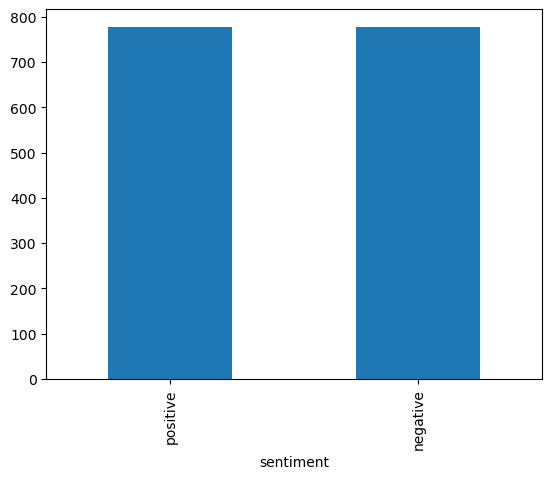

In [73]:
# visualisasi setelah smote
pd.Series(y_train_smote).value_counts().plot(kind='bar')

In [ ]:
# tanpa smote
X_train, y_train = X_train, y_train

## SVM

In [75]:
# model svm
pipeline_svm = Pipeline([
    ('clf', SVC(kernel='linear', random_state=42, probability=True, C=1.0, gamma='auto'))
])

In [76]:
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 SVC(gamma='auto', kernel='linear', probability=True,
                     random_state=42))])

In [77]:
y_pred_svm = pipeline_svm.predict(X_test)

In [78]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.89      0.91      0.90       186
    positive       0.88      0.84      0.85       134

    accuracy                           0.88       320
   macro avg       0.88      0.87      0.88       320
weighted avg       0.88      0.88      0.88       320



In [79]:
print(accuracy_score(y_test, y_pred_svm))

0.88125


In [91]:
# visualisasi confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative', 'positive'])

,negative,positive
negative,170,16
positive,22,112


In [92]:
# svm dengan smote
pipeline_svm_smote = Pipeline([
    ('clf', SVC(kernel='linear', random_state=42, probability=True, C=1.0, gamma='auto'))
])

In [85]:
pipeline_svm_smote.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('clf',
                 SVC(gamma='auto', kernel='linear', probability=True,
                     random_state=42))])

In [86]:
y_pred_svm_smote = pipeline_svm_smote.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred_svm_smote))

              precision    recall  f1-score   support

    negative       0.91      0.88      0.90       186
    positive       0.84      0.88      0.86       134

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.88       320
weighted avg       0.88      0.88      0.88       320



In [88]:
print(accuracy_score(y_test, y_pred_svm_smote))

0.88125


In [93]:
# visualisasi confusion matrix
cm = confusion_matrix(y_test, y_pred_svm_smote)
pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative', 'positive'])

,negative,positive
negative,164,22
positive,16,118


In [95]:
# model naive bayes
pipeline_nb = Pipeline([
    ('clf', MultinomialNB())
])

In [96]:
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [97]:
y_pred_nb = pipeline_nb.predict(X_test)

In [98]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

    negative       0.78      0.96      0.86       186
    positive       0.91      0.63      0.74       134

    accuracy                           0.82       320
   macro avg       0.85      0.79      0.80       320
weighted avg       0.84      0.82      0.81       320



In [99]:
print(accuracy_score(y_test, y_pred_nb))

0.81875


In [101]:
# visualisasi confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative', 'positive'])

,negative,positive
negative,178,8
positive,50,84


In [102]:
# naive bayes dengan smote
pipeline_nb_smote = Pipeline([
    ('clf', MultinomialNB())
])

In [103]:
pipeline_nb_smote.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('clf', MultinomialNB())])

In [104]:
y_pred_nb_smote = pipeline_nb_smote.predict(X_test)

In [105]:
print(classification_report(y_test, y_pred_nb_smote))

              precision    recall  f1-score   support

    negative       0.80      0.94      0.86       186
    positive       0.89      0.67      0.77       134

    accuracy                           0.83       320
   macro avg       0.85      0.81      0.82       320
weighted avg       0.84      0.83      0.82       320



In [106]:
print(accuracy_score(y_test, y_pred_nb_smote))

0.828125


In [107]:
# visualisasi confusion matrix
cm = confusion_matrix(y_test, y_pred_nb_smote)
pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative', 'positive'])

,negative,positive
negative,175,11
positive,44,90


# Evaluasi

In [108]:
print('Accuracy Score SVM:', accuracy_score(y_test, y_pred_svm))
print('Accuracy Score SVM SMOTE:', accuracy_score(y_test, y_pred_svm_smote))
print('Accuracy Score Naive Bayes:', accuracy_score(y_test, y_pred_nb))
print('Accuracy Score Naive Bayes SMOTE:', accuracy_score(y_test, y_pred_nb_smote))

Accuracy Score SVM: 0.88125
Accuracy Score SVM SMOTE: 0.88125
Accuracy Score Naive Bayes: 0.81875
Accuracy Score Naive Bayes SMOTE: 0.828125


<Axes: >

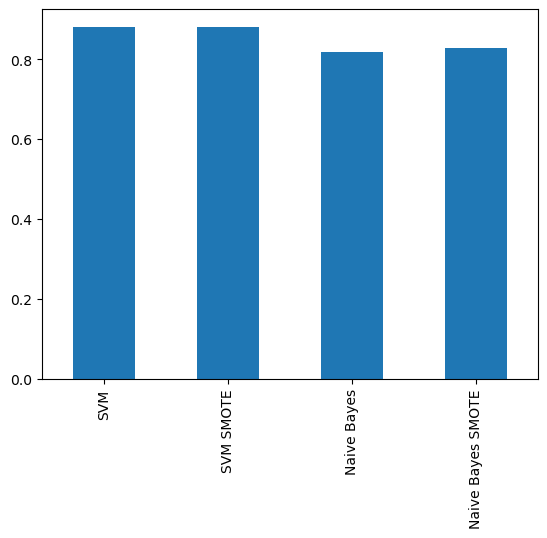

In [109]:
# visualisasi akurasi semua model
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_smote_acc = accuracy_score(y_test, y_pred_svm_smote)
nb_acc = accuracy_score(y_test, y_pred_nb)
nb_smote_acc = accuracy_score(y_test, y_pred_nb_smote)

pd.Series([svm_acc, svm_smote_acc, nb_acc, nb_smote_acc], index=['SVM', 'SVM SMOTE', 'Naive Bayes', 'Naive Bayes SMOTE']).plot(kind='bar')